# Importation code for LFP and DIO data
### needs emk_neuro_analysis environment

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy.stats import circstd
from scipy import stats
from sklearn.linear_model import LinearRegression

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter
import pywt

from collections import deque
from pprint import pprint
from scipy import signal
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

### Experiment parameters

In [2]:
# name of experiment
experiment_name = 'clc'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme1'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
# fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config_laser.xlsx')
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/Maze_YF_clc_Config.xlsx')

# Location of session parameter file
# This is an excel spreadsheet that specifies the CLC parameters used in your experiment
fname_session_parameter = (f'/media/{data_disk}/Data/{experiment_name}/config/clc_session_parameter_record.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220902',]

# choose the epoch - as a list
epoch_list = [1, 2, 3, 4, 5, 6]

# choose the tetrodes - as a list
tet_list = [19]

### Build day records from track config file and experiment file

In [3]:
data_days = []
for curr_date in choose_dates:

    fname_day_record = f'{dir_records}{curr_date}_{experiment_phase}_training_record.xlsx'
    
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name, 
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

dict_sessions_all = bld_exp.build_all_sessions(data_days)
pprint(dict_sessions_all)

{'20220902_01': {'date': '20220902',
                 'description': 'maze stim',
                 'end': Timestamp('2022-09-02 23:55:00'),
                 'experiment': 'clc',
                 'id': 1,
                 'name': 'stim',
                 'start': Timestamp('2022-09-02 01:00:00'),
                 'tasks': {'Track 1': {'animal_id': '6004879',
                                       'description': 'Y',
                                       'dio': {'entry_sensor': {'bit': 11,
                                                                'notes': None,
                                                                'type': 'in'},
                                               'exit_sensor': {'bit': 12,
                                                               'notes': None,
                                                               'type': 'in'},
                                               'laser_pump': {'bit': 2,
                                              

### Import LFP data

In [4]:
lfp_data, lfp_timestamp, _ = lfp_iter.iterate_lfp_load(dir_preprocess,
                                                       tet_list,
                                                       choose_dates,
                                                       epoch_list=epoch_list, 
                                                       remove_movement_artifact=False,
                                                       filter_linenoise=True,
                                                       print_debug=False)

# lfp_func.concatenate_lfptime(lfp_timestamp, df_epoch_lfp)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme1/Data/clc/preprocessing/20220902/20220902_clc_04_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220902/20220902_clc_01_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220902/20220902_clc_05_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220902/20220902_clc_06_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220902/20220902_clc_02_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme1/Data/clc/preprocessing/20220902/20220902_clc_03_stim.LFP tet 19
filter 60Hz noise


### Transform time

In [5]:
time_dict = {}

fs_time = 30000
fs_filter = 1500

for i in lfp_timestamp.items():
    time_curr = i[1]
    time_dict.update({i[0]:{'timestamp':np.array(time_curr),
                            'time':(np.array(time_curr) - time_curr[0])/fs_time}})

### Visualize LFP

<IPython.core.display.Javascript object>


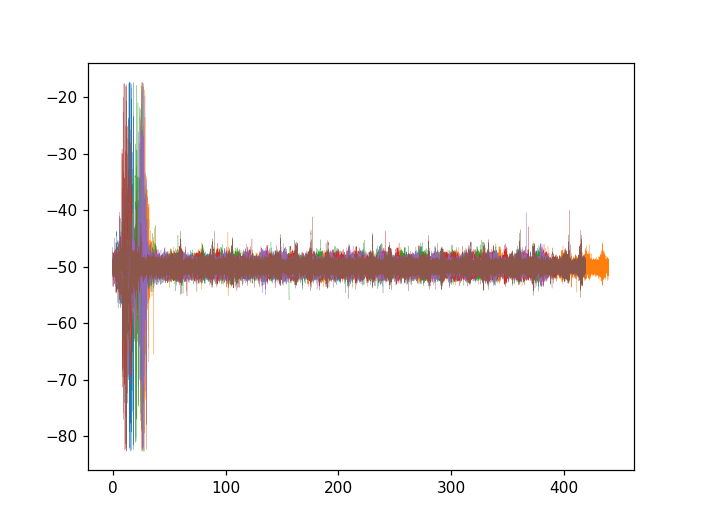

In [6]:
%matplotlib notebook

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
    # for e in [3, 4]:
    
        plt.plot((np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs_time,
                 np.array(v.get(e))/1000+5*(i-10), lw=.15)

### Import DIO data

In [ ]:
# Load DIO
%matplotlib notebook

plot_DIO = False

filter_retrigger = 1000
# filter_retrigger = 0

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=5)
tick_minutes_fmt = mdates.DateFormatter('%H:%M')
tick_minor = mdates.SecondLocator(interval=10)

# Specify parameters
dict_sensor_pump_map = {2: {'pump': 'laser_pump'},
                       }

list_dio = [2,]
y_label = ['laser',]

# plot each session
# get data for each animal
# initiate output
dict_dio_out = {}
dict_dio_in = {}

for animal_id in ['6004879', ]:
    
    print(animal_id)
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all,
                                            experiment_name, trodes_version=2)
    cls_behavior.filter_animals(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue
        
    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False,
                                                   output_raw=False,
                                                   filter_retrigger=None)
    
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False,
                                             output_raw=False,
                                             filter_retrigger=filter_retrigger)
    
    # get unique sessions
    sessions_unique = np.sort(df_pump['session'].unique())
    print(sessions_unique)
    n_subplots = len(sessions_unique)
    
    if plot_DIO:
        fig = plt.figure(figsize=(10, n_subplots*3+2))
        axs = fig.subplots(n_subplots, 1)
        if n_subplots == 1:
            axs = [axs, ]
            sessions_unique = [sessions_unique[0], ]
    
    else:
        axs = [0]*len(sessions_unique)
    
    # divide into sessions
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):
        
        # get session times
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        
        # get sensor and pump times
        df_sensor_curr = df_sensor[df_sensor['session']==session]
        df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start)
                                        & (df_sensor_curr['on_time_sys']<curr_end)]
        dict_dio_in.update({int(session.split('_')[1]): df_sensor_curr})
        
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start)
                                     & (df_pump_curr['on_time_sys']<curr_end)]
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        
        if not plot_DIO:
            continue
        
        # plot DIO data for all sessions
        for i, d in enumerate(list_dio):
            #print(d)
            yval = i+1
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]
            # plot well triggers
            
            for ind, row in df_plot_sensor.iterrows():
                ax.scatter(row['on_time_sys'], yval+.3, s=25, c='k')
                
            for ind, row in df_plot_pump.iterrows():
                
                try:
                    ax.plot([row['on_time_sys'],
                             row['off_time_sys']], [yval+.15, yval+.15], c='r')
                
                except:
                    pass